# Data Wrangling Open Streetmap Data

**Chris Madeley**

27 October 2015

## Table of Contents

1. [Introduction](#1.-Introduction)
1. [Data Parsing and Import](#2.-Data-Parsing-and-Import)
1. [Problems Encountered / Data Corrections](#3.-Problems-Encountered-/-Data-Corrections)
1. [Data Overview and Insight](#4.-Data-Overview-and-Insight)
1. [Conclusions](#5.-Conclusions)

## 1. Introduction

For this assignment the data for Perth, Australia was downloaded from OpenStreetMap using the Overpass API across the coordinate range [(-32.1762, -31.755) (115.677, 116.058)](http://www.openstreetmap.org/export#map=12/-31.9656/115.8671). Perth was chosen for familiarity (born and raised here) and availability of the data.

This assignment is split into two sections, the first describing the data parsing and importing process, the second characterising the database and searching for a few insights into the data.

The bulk of the work has been presented in this notebook interface for clarity.

In [1]:
from __future__ import division, absolute_import

# Data Parsing and Storage
from pymongo import MongoClient
import xml.etree.cElementTree as ET
import re

# Scientific Python Packages
import pandas as pd
from numpy import nan
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data import scripts
from data_parsing import shape_element

## 2. Data Parsing and Import

Data parsing was performed using scripts derived from the Lesson 6 problem set. The useful parts of these scripts have been captured in a module named `data_parsing`, in the same directory as this notebook.

Instead of performing the parsing and cleaning at the same time, it has been divided into two steps. First the data is parsed, and then inserted into a local MongoDB database. Cleaning steps were then performed iteratively as required. This approach was chosen instead of writing to an intermediate json file for a handful of reasons:
- Performing parsing and cleaning simultaneously means rerunning the parsing completely every time you add new rules, this quickly became frustrating.
- MongoDB performance was acceptably fast for the work being performed.
- MongoDB queries make it easy to access nested dictionaries.

In [6]:
client = MongoClient()
db = client['udacity']
osm = db['osm_perth']

In [60]:
file_in = 'osm_data/perth.osm'

The parsing is performed in the following cell. The data is accumulated in a list and exported to MongoDB in one hit at the end. This appears to be faster for this case, and probably will be for all cases where the dataset fits in memory.

In [10]:
i = 0
data = []

print('Parsing Data')
for _, element in ET.iterparse(file_in):
    i += 1
    el = shape_element(element)
    if el:
        data.append(el)
#         osm_data.insert_one(el)
    if i%100000 == 0:
        print i,
    elif i%10000 == 0:
        print '.',

print('\n\nInserting Data into MongoDB')
print '\n',
osm.insert(data)
print('Done!')

Parsing Data
. . . . . . . . . 100000 . . . . . . . . . 200000 . . . . . . . . . 300000 . . . . . . . . . 400000 . . . . . . . . . 500000 . . . . . . . . . 600000 . . . . . . . . . 700000 . . . . . . . . . 800000 . . . . . . . . . 900000 . . . . . . . . . 1000000 . . . . . . . . . 1100000 . . . . . . . . . 1200000 . . . . . . . . . 1300000 . . . . . . . . . 1400000 . . . . . . . . . 1500000 . . . . . . . . . 1600000 . . . . . . . . . 1700000 . . . . . . . . . 1800000 . . . . . . . . . 1900000 . . . . 

Inserting Data into MongoDB

Done!


## 3. Problems Encountered / Data Corrections

The main problem addressed in the cleaning phase was to clean up street names. All the typical problems were seen, such as abbreviations and typos. Additionally, there appear to be a lot of 'unique' street names in some parts of Perth, especially one suburb, where every street has a creative name like *The Quarry*.

An iterative approach was taken to cleaning, with the assistance of pandas dataframes and its groupby function. Streets were grouped by their extension, with listings and counts of the individual names. Acceptable extensions were added to ignore lists, as were unique names. Following this, dictionaries of fixes were built to correct problems in the dataset. These were then applied using the pymongo update function.

The latitude/longitude pairs were also collected in the projection to allow easy cross-checking of locations against Google Maps, which was assumed to be the reference in this case.

In [7]:
cursor = osm.aggregate([
        {'$match':{'address.street':{'$exists':1}}},
        {'$project':{'street_name': '$address.street',
                    'pos': '$pos'}}
    ])
streets_df = pd.DataFrame([_ for _ in cursor])

In [8]:
# Add a column to the dataframe with street 'extensions'
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
def street_extension(x):
    ans = street_type_re.findall(x)
    if len(ans) >= 1:
        return ans[0]
    else:
        return nan
streets_df['extension'] = streets_df.street_name.apply(street_extension)

In [11]:
# List constructed of acceptable, common, street types.
expected = set(['Avenue', 'Boulevard', 'Circle', 'Close', 'Court', 'Cove',
                'Crescent', 'Drive', 'Garden', 'Gardens', 'Grove', 'Highway',
                'Lane', 'Loop', 'Mews', 'Pass', 'Parade', 'Place', 'Rise', 'Road', 'Street',
                'Terrace', 'Trail', 'Way', 'View'])

In [12]:
# Names manually excluded after checking that they really exist
checked_names = set(['Burnby Cross', 'The Heights', 'Liddell Heights', 'The Grange', 'The Elbow',
                    'Talisker Gate', 'Kangaroo Entrance', 'The Elbow', 'Riverton Drive East',
                    'The Promenade', 'Brookside Square', 'The Ramble',
                    'Solway Green', 'Beechboro Road North'])

In [13]:
extension_fixes = {
    'Ave': 'Avenue',
    'Cres': 'Crescent',
    'Rd': 'Road',
    'Road,': 'Road',
    'CRT': 'Court',
    'Crt': 'Court',
    'Ct': 'Court',
    'Crs': 'Crescent',
    'Terriace': 'Terrace',
    'St':'Street',
    'gate': 'Gate',
    'Boulevarde': 'Boulevard', # misspelling
    }
name_fixes = {
    'Morrison' : 'Morrison Road',
    'Oxford': 'Oxford Street',
    'Beaufort': 'Beaufort Street',
    'Tarata Way W/ENT': 'Tarata Way',
    'Tarata Way E/ENT': 'Tarata Way',
    'Tarata Way E/Ent': 'Tarata Way',
    'Tarata Way SW Entrance': 'Tarata Way',
    'Tarata Way E/Ent': 'Tarata Way',
    'Tarata Way E/ENT (Laneway)': 'Tarata Way',
    'Fitzgerald St (corner View St)': 'Fitzgerald Street',
    'Bulwer Steet and Lord St, Highgate': 'Lord Street',
    'E Linden Way (In Laneway)': 'East Linden Way',
    'Fitzgerald St (corner View St)': 'Fitzgerald Street',
    'Beaufort St WA': 'Beaufort Street',
    'Waterford plaza': 'Kent Street',
    }

Both types of corrections are applied by iterating through the pandas dataframe and finding instances where they apply.

In [14]:
for i, r in streets_df.iterrows():
    if r.extension in extension_fixes.keys():
        new_name = street_type_re.sub(extension_fixes[r.extension], r.street_name)
        osm.update_one({'_id':r._id}, {'$set':{'address.street':new_name}})
    if r.street_name in name_fixes.keys():
        new_name = name_fixes[r.street_name]
        osm.update_one({'_id':r._id}, {'$set':{'address.street':new_name}})

Following corrections, the dataframe is rebuilt to look for more errors.

In [16]:
cursor = osm.aggregate([
        {'$match':{'address.street':{'$exists':1}}},
        {'$project':{'street_name': '$address.street',
                    'pos': '$pos'}}
    ])
streets_df = pd.DataFrame([_ for _ in cursor])
streets_df['extension'] = streets_df.street_name.apply(street_extension)

The following filtered dataframe makes aggregated lists of streets that didn't meet the extension of checked name criteria defined above. The remaining streets all appear to be ok.

In [17]:
unknowns = streets_df[~((streets_df.extension.isin(expected))|(streets_df.street_name.isin(checked_names)))]

In [18]:
unknowns.groupby(['extension','street_name'])._id.count()

extension   street_name          
Broadway    Broadway                  1
            The Broadway              1
Circuit     Catalano Circuit         25
            Mordaunt Circuit          1
            Tacoma Circuit            1
            Yorn Circuit              4
Corner      Friday Corner             9
Courtyard   Elia Courtyard           12
Cross       Cockman Cross            87
            Cross                     1
            Lewis Jones Cross        58
Crossway    Crossway                 21
Dale        Altai Dale                9
East        Corinthian Road East      1
Edge        Creek Edge                8
Elbow       Amur Elbow                1
            Drummore Elbow           16
            Hindoo Elbow             27
Entrance    Bombay Entrance          31
            Edwards Entrance         50
            Percheron Entrance       31
Esplanade   South Perth Esplanade     1
            The Esplanade             8
Fairway     Fairway                   1
      

## 4. Data Overview and Insight

### 4.1 Data Size

The download osm file was 147MB. After parsing and importing into MongoDB, this became 217MB.

In [72]:
import os
os.path.getsize(file_in)/(1024**2) # Get the size of the input file in MB

147.2044324874878

In [71]:
db.command("collstats", 'osm_perth')['size']/(1024**2)

217.08474731445312

There are 784750 documents in the database, 87% of them are 'node' documents, the remainder 'way' documents.

In [19]:
osm.count()

784750

In [73]:
osm.count({'type':'node'})/osm.count()
# osm.count({'type':'way'})

0.8732194966549857

A total of 743 users have contributed to the dataset, their contributions will be analysed in more detail in the following section.

In [76]:
len(osm.distinct('created.uid'))

743

### 4.2 User Contributions

To evaluate the contribution of users over time and space, a dataframe was constructed that included the user_id, position and creation time of every node in the database.

In [24]:
node_df = [{'time':x['created']['timestamp'], 'lat':x['pos'][0], 'lon':x['pos'][1],
            'user': x['created']['uid']}
                   for x in osm.find({'type':'node'}, ['created.timestamp', 'pos', 'created.uid'])]
node_df = pd.DataFrame(node_df)
node_df.time = pd.to_datetime(node_df.time)

Grouping the dataframe by user allows us to see the number of contributions made by each user. What we find is that the top 5 contributors account for 61% of the node entries.

In [77]:
user_contrib = node_df.groupby('user').time.count()
user_contrib.sort(ascending=False)
user_contrib[:5].sum()/len(node_df)

0.60738494496241568

When we plot the cumulative contribution of the users when sorted, it is clear that a small minority of the 743 total contributors have added a clear majority of the data to the database.

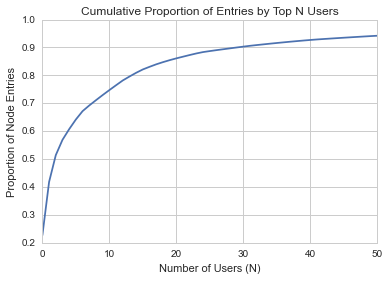

In [78]:
sns.set_style('whitegrid')
plt.plot(np.cumsum(user_contrib)/np.sum(user_contrib))
plt.xlim(0,50)
plt.xlabel('Number of Users (N)')
plt.ylabel('Proportion of Node Entries')
plt.title('Cumulative Proportion of Entries by Top N Users')
plt.show()

### 4.3 Plotting Contributions Spatially

Next we evaluate where users contribute spatially, shown on the following plot. Firstly, some of the natural geographic borders of the city are clear, such as the river and the ocean. What we notice about the top five contributors, is that they have each contributed largely to different parts of the city. Purple had added a lot to the northern suburbs, Green a lot to the southern suburbs. Red is the greatest contributor and has added a lot in the city centre, the eastern suburbs and all up and down the hills in the east. Most interesting of all the contributors is Blue, who has added a heavy concentration of nodes in one eastern location only, out in the suburbs.

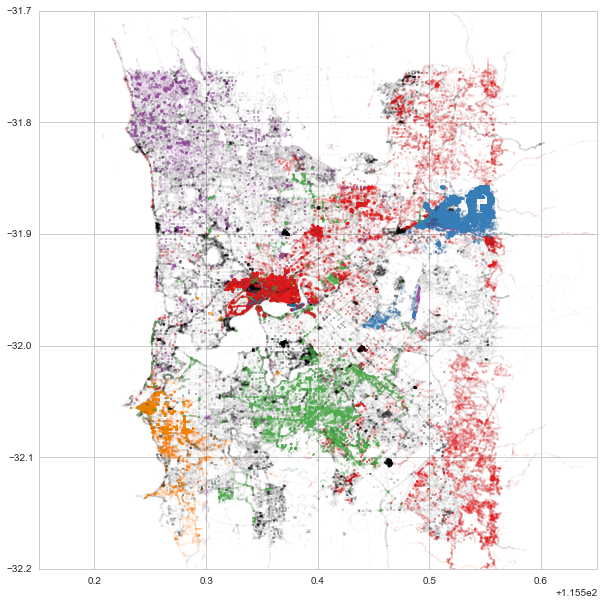

In [79]:
colors = sns.color_palette("Set1", 10)
plt.figure(figsize=[10,10])

# Plot the positions contributed by non-top-5 contributors
temp_df = node_df[~node_df.user.isin(user_contrib[:5].index)]
plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=0.2, color = 'k')

# Plot the node positions for the top five contributors
for i, usr in enumerate(user_contrib[:5].index):
    temp_df = node_df[node_df.user == usr]
    plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=0.4, color = colors[i])

plt.xlim(115.65,116.15)
plt.ylim(-32.2, -31.7)
plt.show()

Looking the dense point more closely, the structure of the suburb is reasonably apparent, except that the streets form the whitespace, and dwellings the dark space. Visiting this location on OpenStreetMap reveals that this user has drawn the outlines of every dwelling on OpenStreetMap for this suburb, leading to the extremely high density of points in this area. The rest of Perth is missing this level of detail, which causes the dataset to be extremely unbalanced in its representation of Perth.

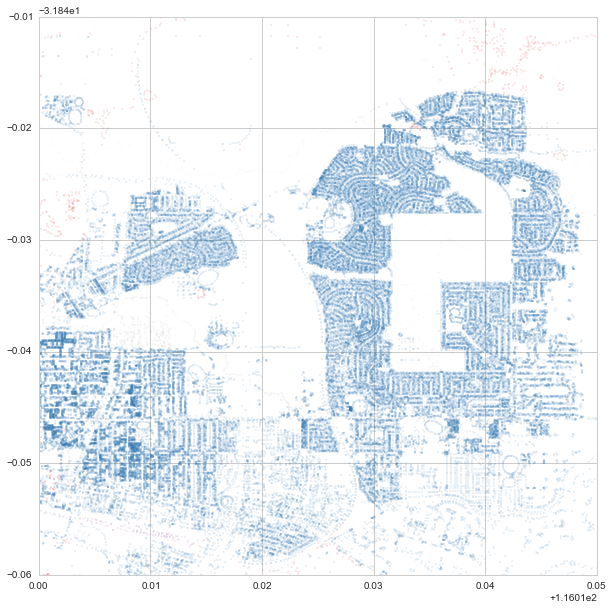

In [41]:
plt.figure(figsize=[10,10])

temp_df = node_df[~node_df.user.isin(user_contrib[:5].index)]
plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=0.2, color = 'k')

for i, usr in enumerate(user_contrib[:5].index):
    temp_df = node_df[node_df.user == usr]
    plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=1, color = colors[i])

plt.xlim(116.01,116.06)
plt.ylim(-31.9, -31.85)
plt.show()


### 4.4 Plotting Contributions Temporally

Next the contribution of users over time was examined. When we plot the total number of contributions over time we see a large peak in 2012 and 2013, with activity tailing off more recently.

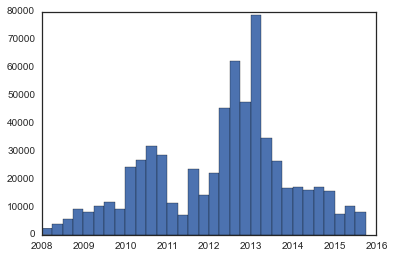

In [83]:
# This is obviously only approximate, but is sufficient for these visualisations.
node_df['decimal_date'] = node_df.time.apply(lambda x: x.year + x.month/12 + x.day/31)
plt.hist(node_df.decimal_date, bins= np.arange(2008, 2016, 1/4))
plt.xticks(range(2008,2017), range(2008, 2017))
plt.show()

Breaking the contributions down by user reveals more interesting patterns. The number of entries per quarter for each of the top 10 contributors is shown below. It is clear that most of the top contributors, with the exception of Orange, makes almost all of their additions over a period of 2-3 years, and only 2/10 top contributors are still activily contributing today.

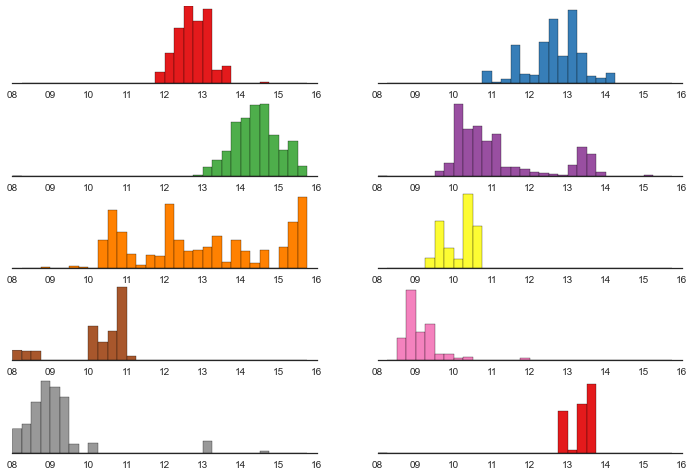

In [82]:
sns.set_style('white')
plt.figure(figsize=[12,8])

for i, usr in enumerate(user_contrib[:10].index):
    plt.subplot(5,2,i+1)
    temp_df = node_df[node_df.user == usr]
    plt.hist(temp_df.decimal_date.tolist(), bins= np.arange(2008, 2016, 1/4), color=colors[i])
    plt.xticks(range(2008,2017), [str(x)[-2:] for x in range(2008,2017)])
    plt.yticks([0],[''])
    sns.despine(left=True)
plt.show()


The following plot shows each node colored by when it was added. Although the data does have patterns, they are broadly a combination of the spatial additions of each user combined with when they were actively contributing. For example the far northern suburbs were added by Purple, one of the earliest contributors. Conversely, the southern regions have been populated by Green, a more recent contributor.

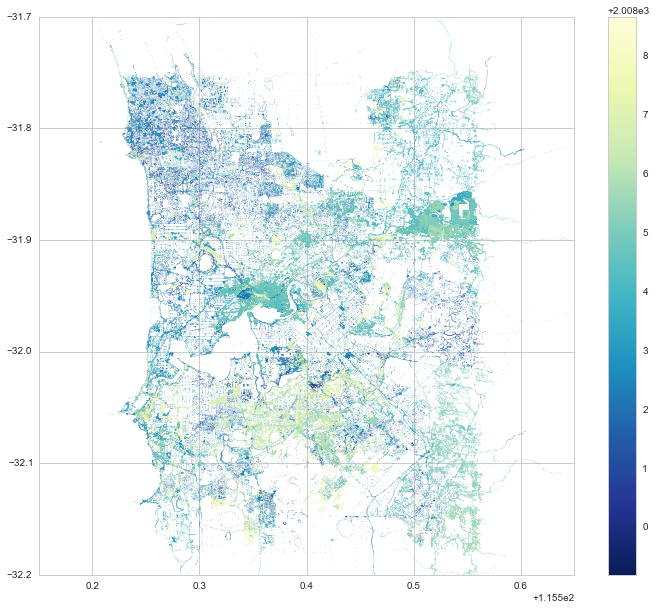

In [85]:
sns.set_style('whitegrid')
plt.figure(figsize=[12,10])
plt.scatter(node_df.lon, node_df.lat, c=node_df.decimal_date, s=0.2, alpha=1, cmap='YlGnBu_r', lw=0)
plt.colorbar()
plt.xlim(115.65,116.15)
plt.ylim(-32.2, -31.7)
plt.show()

### 4.5 Unlucky 13

The following function was written to aggregate the 10 most frequent values that appear for any given key to search for patterns or interesting features in the values.

In [52]:
def top_10(key, num=10):
    cursor = osm.aggregate([
            {'$match': {key: {'$exists':1}}},
            {'$group': {'_id':'$'+key, 
                        'count':{'$sum':1}}},
            {'$sort' : {'count':-1}},
            {'$limit': num}
        ])
    return [i for i in cursor]

One interesting observation was stumbled upon when looking at the frequency of house numbers. Although there is a steady decline in the house numbers over time, as exected, there is a substantial outlier for the number 13, which appears to be around 30% less frequent than expected. Clearly the superstition is quite powerful for some people when numbering houses. Does this mean any street with more than 13 houses never lines up the odd and even houses on opposite sides of the street?

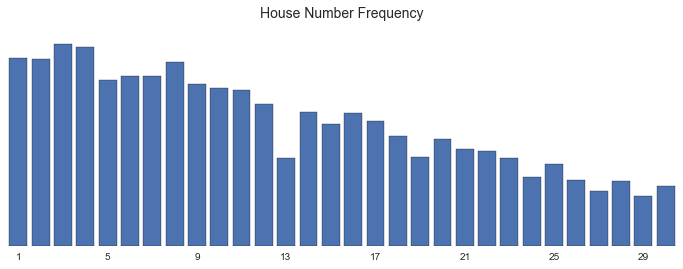

In [86]:
sns.set_style('white')
pop_numbers = top_10('address.housenumber', 200)
numdf = pd.DataFrame(pop_numbers)
def try_int(x):
    try:
        return int(x)
    except:
        return nan
numdf._id = numdf._id.apply(try_int)
numdf = numdf.dropna()

plt.figure(figsize=[12,4])
plt.bar(numdf._id-0.4, numdf['count'], width=0.8)
plt.xticks(range(1,31,4))
plt.yticks([])
plt.xlim(0.5,30.5)
plt.title('House Number Frequency', fontsize=14)
sns.despine(left=True, bottom=True)

### 4.6 Other Observations

A handful of other aspects of the data have also been briefly looked at.

In [89]:
# Lists all available keys.
# available_keys = {}
# for i in osm.find():
#     for k,v in i.iteritems():
#         available_keys[k] = available_keys.get(k, 0) + 1
#         if isinstance(v, dict):
#             for m,n in v.iteritems():
#                 available_keys['{}.{}'.format(k,m)] = available_keys.get('{}.{}'.format(k,m), 0) + 1
# keys = pd.Series(available_keys)
# keys.sort(ascending=False)
# keys[:40]

When considering amenities, OpenStreetMaps lists only one more restaurant than fast-food place for Perth.

In [53]:
top_10('amenity')

[{u'_id': u'parking', u'count': 1814},
 {u'_id': u'school', u'count': 395},
 {u'_id': u'restaurant', u'count': 236},
 {u'_id': u'fast_food', u'count': 235},
 {u'_id': u'bench', u'count': 230},
 {u'_id': u'cafe', u'count': 212},
 {u'_id': u'post_box', u'count': 205},
 {u'_id': u'place_of_worship', u'count': 183},
 {u'_id': u'drinking_water', u'count': 179},
 {u'_id': u'telephone', u'count': 151}]

OpenStreetMaps counts 519 traffic signals in Perth, whereas [Department of Main Roads](https://www.mainroads.wa.gov.au/UsingRoads/RoadTrafficInformation/Pages/trafficsignals.aspx) says there are over 850. Clearly some aspects of the data are very incomplete.

In [90]:
top_10('crossing')

[{u'_id': u'uncontrolled', u'count': 1169},
 {u'_id': u'traffic_signals', u'count': 519},
 {u'_id': u'island', u'count': 57},
 {u'_id': u'unmarked', u'count': 40},
 {u'_id': u'island;uncontrolled', u'count': 8},
 {u'_id': u'zebra', u'count': 5},
 {u'_id': u'unknown', u'count': 4},
 {u'_id': u'uncontrolled; island', u'count': 1}]

The 'city' count for various suburbs is grossly mis-weighted to areas that have had substantial attention. The weighting of where detail exists in the data probably says a lot more about the contributors than the city.

In [54]:
top_10('address.city')

[{u'_id': u'Stratton', u'count': 1319},
 {u'_id': u'Jane Brook', u'count': 1022},
 {u'_id': u'Swan View', u'count': 716},
 {u'_id': u'Willetton', u'count': 652},
 {u'_id': u'West Perth', u'count': 638},
 {u'_id': u'Canning Vale', u'count': 566},
 {u'_id': u'Perth', u'count': 155},
 {u'_id': u'Bull Creek', u'count': 140},
 {u'_id': u'South Lake', u'count': 109},
 {u'_id': u'Bibra Lake', u'count': 87}]

## 5. Conclusions

Following the parsing and analysis of the OpenStreetMap data for Perth it is clear that the quality and consistency varies greatly across the city. As expected, a dozen contributors have done the bulk of the work, which has led to excellent detail in some regions, but very little in others. It appears that most of the heaviest contributors add to the database for around 2 years, continued output appears to be very uncommon.